In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane_imager import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg_imager.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))
arg_spaxel['plate_scale']=0.005
fov = (arg_spaxel['plate_scale']*arg_spaxel['detector_px'])**2
#arg_spaxel

(1600, 1600)


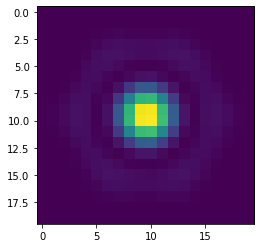

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck
print(keck.shape)

mag = magn(3.6)
W = DFT_matrix(1600, mag)
screen1 = np.zeros(W.shape)
A = pupil.pupil * np.exp(1.j * screen1)
out = abs(W.dot(A).dot(W))**2
out /= np.sum(out, axis=(0,1))
im = frebin(out, (108, 108))
plt.imshow(im[54-10:54+10,54-10:54+10])
plt.show()

## Read in Keck pupil

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

3.6


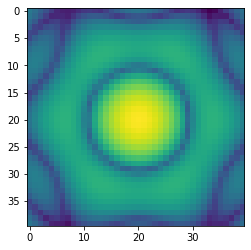

[0.9     0.90002 0.90004 ... 5.59994 5.59996 5.59998] micron
[4.013827 4.014692 4.015557 ... 5.391358 5.392222 5.392222] micron
[[66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]
 [66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]
 [66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]
 ...
 [66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]
 [66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]
 [66913.05096594 66913.05096594 66913.05096594 ... 66913.05096594
  66913.05096594 66913.05096594]]


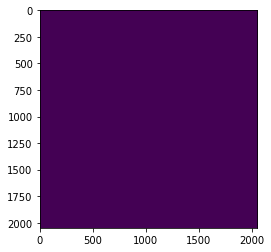

NameError: name 'stop' is not defined

In [6]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
modes = [[2.0,5.2]]
for wavs in modes:
    wav_min,wav_max = wavs
    arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
    arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns
    
    nspax = arg_spaxel['detector_px']

    
    lamc = np.round(np.mean([wav_min,wav_max]),3)
    print(lamc)
    
    keckp = fits.getdata('keckpupil.fits')
    mpp = 10.0/len(keckp)
    mpp_des = 1.0/(2048.0*0.01)*206265.0*lamc*1.0e-6
    keckt = scipy.ndimage.zoom(keckp, mpp/mpp_des, order=0)
    keckt = np.pad(keckt,1000)
    pupil = Pupil()
    pupil.pupil = keckt
    screen1 = np.zeros(pupil.pupil.shape)
    
    #mag1 = magn(lamc)
    mag1 = 1.0

    psf_file = 'keck_psf_cube_'+str(lamc)+'_imager.fits'
    #if os.path.isfile(psf_file)==False:
    W = DFT_matrix(len(pupil.pupil), mag1)
    A = pupil.pupil * np.exp(1.j * screen1)
    out = abs(W.dot(A).dot(W))**2
    out /= np.sum(out, axis=(0,1))
    keck_psf = frebin(out, (nspax,nspax))
    fits.writeto(psf_file,np.array(keck_psf),clobber=True)
    #else: keck_psf = pyfits.getdata(psf_file)
    plt.imshow(keck_psf[1024-20:1024+20,1024-20:1024+20]**0.1)
    plt.show()

    
    vapor = 1 #PWV in mm
    airmass = 1 
    skybg = SkyBG(vapor,airmass)
    skytrans = SkyTrans(vapor,airmass)
    atmodisp = AtmoDispersion(90,20,600)

    telAO_emissivities = [0.4]
    telAO_temps = [285*u.K]
    scales_trans = [0.5454920871]
    inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
    
    qe = QE()
    filt = ImagerFilter(filename='nirc2_Ms.txt')
    dit = 1 ###integration time in seconds
    
    ####organize all these and pass to focal_plane 
    args_new = {
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe,
            'FOV':fov, ###fov in square arcsec
            'area':arg_spaxel['area'],
            'DetectorPix':2048
                }
    fp = FocalPlaneImager(args_new)
    
    
    
    raw = fp.get_fp(dit*u.s,return_full=True,
                                  bg_off=False, return_phots=True)
    #rawfile = 'detector_'+str(wav_min)+'_'+str(wav_max)+'.fits'
    #pyfits.writeto(rawfile,np.array(raw),clobber=True)
    plt.imshow(raw)
    plt.show()
    stop